In [1]:
%matplotlib inline

# Apply CP decomposition to COVID-19 Serology Dataset

### Introduction

PARAFAC (CP) decomposition is extremely useful in dimensionality reduction, allowing us to develop models that are both representative and compact while retaining crucial patterns between subjects. Here, we provide an example of how it can be applied to biomedical research. 

Systems serology is a new technology that examines the antibodies from a patient's serum, aiming to comprehensively profile the interactions between the antibodies and [Fc receptors](https://en.wikipedia.org/wiki/Fc_receptor) alongside other types of immunological and demographic data. Here, we will apply CP decomposition to a [COVID-19 system serology dataset](https://www.sciencedirect.com/science/article/pii/S0092867420314598). Details of this analysis as well as more in-depth biological implication can be found in [this work](https://www.embopress.org/doi/full/10.15252/msb.202110243).

We first import this dataset of a panel of COVID-19 patients:

In [2]:
import numpy as np
import pandas as pd

def importData():
    Cov = pd.read_csv("https://raw.githubusercontent.com/meyer-lab/systemsSerology/main/syserol/data/ZoharCovData.csv", index_col=0)
    # 23 (0-> 23) is the start of IgG1_S
    Demographics = Cov.iloc[:, 0:23]
    Serology = Cov.iloc[:, 23::]
    Serology -= Serology.loc["PBS"].values.squeeze()
    df = pd.concat([Demographics, Serology], axis=1)
    df = df.loc[np.isfinite(df["patient_ID"]), :]
    df["week"] = np.array(df["days"] // 7 + 1.0, dtype=int)
    df["patient_ID"] = df["patient_ID"].astype('int32')
    df["group"] = pd.Categorical(df["group"], ["Negative", "Mild", "Moderate", "Severe", "Deceased"])
    df = df.sort_values(by=["group", "days", "patient_ID"])
    return df.reset_index()

importData()

,sample_ID,patient_ID,age,sex,COVID,immunosup,hospitalized,death_COVID,ICU,group,...,FcR2B_NL63,FcR2B_HKU1,FcR2B_flu_mix,FcR3A_NL63,FcR3A_HKU1,FcR3A_flu_mix,FcR3B_NL63,FcR3B_HKU1,FcR3B_flu_mix,week
0,1_43,23,97.0,M,N,0,1,0,0,Negative,...,480149.00,564678.00,1437753.50,61303.00,57279.75,1538409.00,58856.50,56065.25,1010657.50,1
1,4_74,205,21.0,M,N,0,1,0,1,Negative,...,131161.75,157113.00,281237.75,2495.50,2161.50,44651.75,22322.75,39258.50,145088.00,1
2,1_42,23,97.0,M,N,0,1,0,0,Negative,...,21795.00,29419.50,613104.50,176.50,9.25,163417.75,487.50,184.75,100979.25,1
3,4_73,204,36.0,F,N,0,1,0,1,Negative,...,19328.25,7003.25,902298.00,470.25,-83.25,558736.75,908.75,-176.25,393842.00,1
4,1_33,21,64.0,M,N,0,1,0,1,Negative,...,42810.00,7965.50,239633.00,1134.50,304.00,43519.25,3670.50,714.00,150331.50,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433,2_76,86,59.0,M,P,0,1,1,1,Deceased,...,253958.25,476045.00,1784936.75,70646.50,178645.25,2263831.50,61810.25,163136.00,1882969.75,5
434,2_77,86,59.0,M,P,0,1,1,1,Deceased,...,70300.50,159378.25,1616044.75,8579.75,24788.50,2055521.00,2952.25,11522.00,1645874.50,5
435,4_36,171,72.0,M,P,0,1,1,0,Deceased,...,86743.75,18985.50,1069527.50,30564.00,574.75,1360522.25,16045.75,758.50,1154776.25,5
436,2_78,86,59.0,M,P,0,1,1,1,Deceased,...,652357.25,916556.75,1947746.50,264073.00,542923.00,2298166.50,173773.00,367417.00,1857548.00,6


### Reshape the dataset to a tensor

To better analyze the data, we reshape this dataset to a three-mode tensor. The functionality of an antibody can be characterized by two effects: (1) the antigen its [Fab region](https://en.wikipedia.org/wiki/Fragment_antigen-binding) is specific to; (2) their [Fc region](https://en.wikipedia.org/wiki/Fragment_crystallizable_region) engagement. We separate their effect into two distinct tensor modes.

In [3]:
receptorLabels = ["IgG1","IgG2","IgG3","IgA1","IgA2","IgM","FcRalpha","FcR2A","FcR2B","FcR3A","FcR3B"]
antigenLabels = ["S", "RBD", "N", "S1", "S2", "S1 Trimer"]

df = importData()
tensor = np.full((len(df), len(antigenLabels), len(receptorLabels)), np.nan)

for rii, recp in enumerate(receptorLabels):
     for aii, anti in enumerate(antigenLabels):
        dfAR = df[recp + "_" + anti]
        tensor[:, aii, rii] = dfAR.values

# Some data preprocessing: clip off small measurements, logscale, then mean center
tensor = np.clip(tensor, 10.0, None)
tensor = np.log10(tensor)
tensor -= np.nanmean(tensor, axis=0)

tensor.shape

(438, 6, 11)

### Apply CP decomposition to this dataset with Tensorly

Now we apply CP decomposition to this dataset.

In [4]:
import tensorly as tl
from tensorly.decomposition import parafac

comps = np.arange(1, 7)

CMTFfacs = [parafac(tensor, cc, tol=1e-10, n_iter_max=1000,
                    linesearch=True, orthogonalise=2) for cc in comps]

To evaluate how well CP decomposition explains the variance in the dataset, we plot the percent variance reconstructed (R2X) for a range of ranks.

In [5]:
def calcR2X(tFac, tIn=None, mIn=None):
    assert (tIn is not None) or (mIn is not None)

    vTop, vBottom = 0.0, 0.0

    if tIn is not None:
        tMask = np.isfinite(tIn)
        vTop += np.sum(np.square(tl.cp_to_tensor(tFac) * tMask - np.nan_to_num(tIn)))
        vBottom += np.sum(np.square(np.nan_to_num(tIn)))
    if mIn is not None:
        mMask = np.isfinite(mIn)
        recon = tFac if isinstance(tFac, np.ndarray) else buildGlycan(tFac)
        vTop += np.sum(np.square(recon * mMask - np.nan_to_num(mIn)))
        vBottom += np.sum(np.square(np.nan_to_num(mIn)))

    return 1.0 - vTop / vBottom

[0.67416805 0.74406695 0.77865174 0.81020019 0.8337573  0.8530664 ]


(0.0, 6.5)

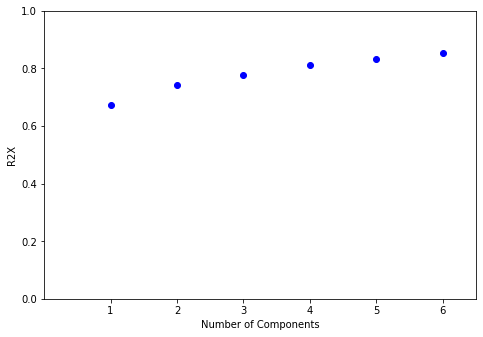

In [6]:
import matplotlib
from matplotlib import gridspec, pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
CMTFR2X = np.array([calcR2X(f, tensor) for f in CMTFfacs])
print(CMTFR2X)
ax.plot(comps, CMTFR2X, "bo")
ax.set_ylabel("R2X")
ax.set_xlabel("Number of Components")
ax.set_xticks([x for x in comps])
ax.set_xticklabels([x for x in comps])
ax.set_ylim(0, 1)
ax.set_xlim(0.0, np.amax(comps) + 0.5)

### Build a Logistic Regression classifier to predict severe versus deceased COVID-19 patients

An important function of CP decomposition here is to reduce data while keeping significant information.

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import KFold

tfac = CMTFfacs[1]

# Ensure that factors are negative on at most one direction. 
tfac.factors[1][:, 0] *= -1
tfac.factors[2][:, 0] *= -1

def COVIDpredict(tfac):
    df = importData()
    subjj = df["group"].isin(["Severe", "Deceased"])

    X = tfac.factors[0][subjj, :]
    y = pd.factorize(df.loc[subjj, "group"])[0]
    aucs = []

    kf = KFold(n_splits=10, shuffle=True)
    outt = pd.DataFrame(columns=["fold", "FPR", "TPR"])
    for ii, (train, test) in enumerate(kf.split(X)):
        model = LogisticRegression().fit(X[train], y[train])
        y_score = model.predict_proba(X[test])
        fpr, tpr, _ = roc_curve(y[test], y_score[:, 1])
        aucs.append(roc_auc_score(y[test], y_score[:, 1]))
        outt = pd.concat([outt, pd.DataFrame(data={"fold": [ii+1] * len(fpr), "FPR": fpr, "TPR": tpr})])

    xs = pd.unique(outt["FPR"])
    ipl = pd.DataFrame(columns=["fold", "FPR", "TPR"])
    for ii in range(kf.n_splits):
        ys = np.interp(xs, outt.loc[outt["fold"]==(ii+1), "FPR"], outt.loc[outt["fold"]==(ii+1), "TPR"])
        ys[0] = 0
        ipl = pd.concat([ipl, pd.DataFrame(data={"fold": [(ii+1)] * len(xs), "FPR": xs, "TPR": ys})])

    return ipl, aucs

In [8]:
roc_df, auc = COVIDpredict(tfac)
roc_sum = roc_df.groupby(['FPR'], as_index=False).agg({'TPR': ['mean', 'sem']})

Text(0.5, 1.0, 'Severe vs. Deceased ROC (AUC=0.72±0.03)')

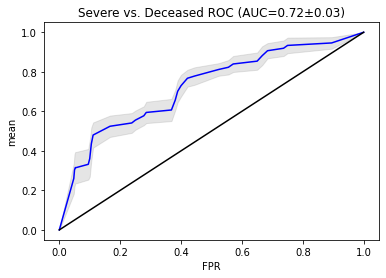

In [9]:
import seaborn as sns
from scipy.stats import sem

ax = sns.lineplot(x=roc_sum["FPR"], y=roc_sum["TPR"]["mean"], color='b')
sns.lineplot(x=[0, 1], y=[0, 1], color="black", ax=ax)
tprs_upper = np.minimum(roc_sum["TPR"]["mean"] + roc_sum["TPR"]["sem"], 1)
tprs_lower = np.maximum(roc_sum["TPR"]["mean"] - roc_sum["TPR"]["sem"], 0)
ax.fill_between(roc_sum["FPR"], tprs_lower,
                   tprs_upper, color='grey', alpha=.2)
ax.set_title("Severe vs. Deceased ROC (AUC={}±{})".format(np.around(np.mean(auc), decimals=2),
                                                             np.around(sem(auc), decimals=2)))

### Inspect the biological insights from CP components
Eventually, we wish CP decomposition can 

In [10]:
from itertools import groupby

def comp_plot(factors, xlabel, ylabel, plotLabel, ax, d=False):
    """ Creates heatmap plots for each input dimension by component. """
    scales = np.linalg.norm(factors, ord=np.inf, axis=0)
    factors /= scales
    if d:
        b = [list(g) for _, g in groupby(ylabel)]
        newLabels = []
        for i, c in enumerate(b):
            newLabels.append([x + "  " if i == len(c)//2 else "–" if i ==
                              0 or i == len(c) - 1 else "·" for (i, x) in enumerate(c)])

        newLabels = [item for sublist in newLabels for item in sublist]

        sns.heatmap(factors, cmap="PiYG", center=0,
                    xticklabels=xlabel, yticklabels=newLabels, ax=ax)
    else:
        sns.heatmap(factors, cmap="PiYG", center=0,
                    xticklabels=xlabel, yticklabels=ylabel, ax=ax)
    ax.set_xlabel("Components")
    ax.set_title(plotLabel)

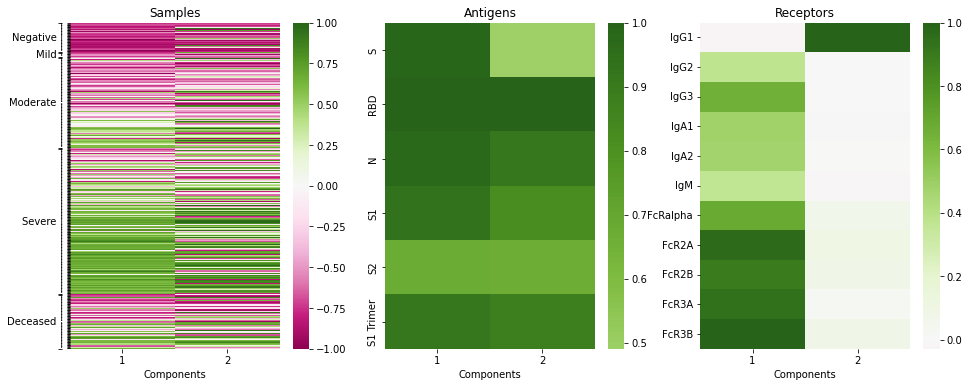

In [11]:
components = [str(ii + 1) for ii in range(tfac.rank)]

fig, axes = plt.subplots(1, 3, figsize=(16,6))
comp_plot(tfac.factors[0], components, list(importData()['group']), "Samples", axes[0], True)
comp_plot(tfac.factors[1], components, antigenLabels, "Antigens", axes[1])
comp_plot(tfac.factors[2], components, receptorLabels, "Receptors", axes[2])

From the results, we can see that serum COVID-19 immunity separates into two distinct signals, represented by two CP components: a clear acute response with IgG3, IgM, and IgA, and a long-term, IgG1-specific response. Samples from patients with different symptoms can be distinguish from these two components. This indicates that CP decomposition is a great tool to find these biologically significant signals.

# Reference
[1] Tan, Z. C., Murphy, M. C., Alpay, H. S., Taylor, S. D., & Meyer, A. S. (2021). Tensor‐structured decomposition improves systems serology analysis. Molecular systems biology, 17(9), e10243.

[2] Zohar, T., Loos, C., Fischinger, S., Atyeo, C., Wang, C., Slein, M. D., ... & Alter, G. (2020). Compromised humoral functional evolution tracks with SARS-CoV-2 mortality. Cell, 183(6), 1508-1519.